# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Project Analysis and Final Recommendations](#ProjectAnalysis)<br>
VII. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from subprocess import call

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

C:\Users\Makarand\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape,df_content.shape

((45993, 3), (1056, 5))

In [4]:
# Group by 'email' to get user-article interaction counts
user_article_counts = df.groupby("email")["article_id"].count()

In [5]:
# Fill in the median and maximum number of user_article interactios below
median_val =  np.median(user_article_counts) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =  user_article_counts.max() # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
# Find duplicate rows (same user and article combination)
duplicate_interactions = df[df.duplicated(subset=["email", "article_id"], keep=False)]

print(f"Total duplicate interactions: {duplicate_interactions.shape[0]}")
#print(duplicate_interactions.head())

Total duplicate interactions: 18854


In [7]:
# Find duplicate article IDs in articles_community.csv
duplicate_articles = df_content[df_content.duplicated(subset=["article_id"], keep=False)]

print(f"Total duplicate articles: {duplicate_articles.shape[0]}")
#print(duplicate_articles.head())

Total duplicate articles: 10


In [8]:
# Remove any rows that have the same article_id - only keep the first

# Remove duplicates based on article_id
df_interactions_cleaned = df.drop_duplicates(subset=["email", "article_id"], keep="first")

# Check the shape of the cleaned DataFrame
print(f"Original df shape: {df.shape}")
print(f"Cleaned df shape: {df_interactions_cleaned.shape}")

# Remove duplicates based on article_id and keep the first occurrence
df_content_cleaned = df_content.drop_duplicates(subset=["article_id"], keep="first")

# Check the shape of the cleaned DataFrame
print(f"Original df_content shape: {df_content.shape}")
print(f"Cleaned df_content shape: {df_content_cleaned.shape}")

Original df shape: (45993, 3)
Cleaned df shape: (33682, 3)
Original df_content shape: (1056, 5)
Cleaned df_content shape: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
unique_articles = df_interactions_cleaned["article_id"].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content_cleaned.shape[0] # The number of unique articles on the IBM platform
unique_users = df_interactions_cleaned["email"].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [10]:
# Group by 'article_id' and count the number of interactions ('email') for each article
article_view_counts = df.groupby("article_id")["email"].count()

most_viewed_article_id = str(article_view_counts.idxmax()) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = article_view_counts.max() # The most viewed article in the dataset was viewed how many times?

In [11]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [12]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [13]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    Description:
    This function identifies the top `n` articles with the highest number of interactions 
    and retrieves their titles.
    '''
    # Group the dataframe by article titles and count the interactions
    title_interactions = df.groupby('title').size().reset_index(name='interaction_count')
    
    # Sort the articles by interaction count in descending order
    sorted_titles = title_interactions.sort_values(by='interaction_count', ascending=False)
    
    # Select the top n titles
    top_articles = sorted_titles['title'].head(n).tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article IDs 
    
    Description:
    This function identifies the top `n` articles with the highest number of interactions 
    and retrieves their unique IDs.
    '''
    # Group the dataframe by article IDs and count the interactions
    article_interactions = df.groupby('article_id').size().reset_index(name='interaction_count')
    
    # Sort the articles by interaction count in descending order
    sorted_ids = article_interactions.sort_values(by='interaction_count', ascending=False)
    
    # Select the top n article IDs as strings
    top_article_ids = sorted_ids['article_id'].head(n).astype(str).tolist()
    
    return top_article_ids

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)


# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [16]:
# Create the user-article matrix with 1's and 0's using pivot table and NumPy

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item matrix 
    
    Description:
    This function creates a matrix where each row corresponds to a user_id, 
    and each column corresponds to an article_id. The matrix contains 1 if the 
    user interacted with the article, and 0 otherwise.
    '''
    # Use pivot_table to construct the user-item matrix
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=0)
    
    # Save the original index and columns
    index = user_item.index
    columns = user_item.columns
    
    # Convert all non-zero values to 1 using NumPy
    user_item = (user_item.values > 0).astype(int)
    
    # Reconstruct the DataFrame with the original index and columns
    user_item = pd.DataFrame(user_item, index=index, columns=columns)
    
    return user_item

# Generate the user-item matrix
user_item = create_user_item_matrix(df)

In [17]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [18]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product.
    Returns an ordered list of users based on similarity, excluding the user_id itself.
    '''
    # Compute similarity for all users with the given user
    user_similarity_scores = user_item @ user_item.loc[user_id]
    
    # Convert the Series to a DataFrame
    similarity_df = user_similarity_scores.reset_index()
    similarity_df.columns = ['user_id', 'similarity']
    
    # Exclude the target user and sort by similarity in descending order
    similarity_df = similarity_df[similarity_df['user_id'] != user_id].sort_values(by='similarity', ascending=False)
    
    # Extract the sorted user IDs as a list
    similar_users = similarity_df['user_id'].tolist()
    
    return similar_users  # Return the list of user_ids sorted by similarity

In [19]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [20]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    
    Description:
    Returns the article titles corresponding to the provided article IDs.
    '''
    # Create a dictionary to map article IDs to titles
    id_to_title = df.set_index('article_id')['title'].to_dict()
    
    # Use list comprehension to retrieve titles for the given article IDs
    article_names = [id_to_title.get(float(article_id), "Unknown") for article_id in article_ids]
    
    return article_names  # Return the article names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Extracts the article IDs and titles that the user has interacted with.
    '''
    # Identify the row corresponding to the user
    user_row = user_item.loc[user_id]
    
    # Find article IDs where the user has interacted
    article_ids = [col for col, val in zip(user_row.index, user_row.values) if val == 1]
    
    # Convert article IDs to strings
    article_ids = list(map(str, article_ids))
    
    # Retrieve article names using the helper function
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Finds articles the user hasn't seen before and provides recommendations 
    based on similar users.
    '''
    # Step 1: Fetch the articles already seen by the user
    user_articles, user_articles_names = get_user_articles(user_id)
    
    # Step 2: Find similar users and initialize recommendation tracking
    similar_users = find_similar_users(user_id)
    unseen_articles = []
    
    # Step 3: Traverse through similar users to gather recommendations
    for similar_user in similar_users:
        articles_by_user, articles_by_user_name = get_user_articles(similar_user)
        
        # Append unseen articles to the list
        unseen_articles.extend([article for article in articles_by_user if article not in user_articles])
        
        # Stop if enough recommendations are found
        if len(set(unseen_articles)) >= m:
            break
    
    # Step 4: Ensure consistent ordering and limit recommendations to 'm'
    unseen_articles = list(dict.fromkeys(unseen_articles))  # Remove duplicates while preserving order
    recs = unseen_articles[:m]
    
    return recs

In [21]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [22]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
    '''
    # Compute the similarity using numpy for efficiency and clarity
    user_similarity_scores = np.dot(user_item, user_item.loc[user_id].values)

    # Create a DataFrame to store the similarity scores
    similarity_data = pd.DataFrame({
        'user_id': user_item.index,
        'similarity': user_similarity_scores
    }).query('user_id != @user_id')  # Filter out the current user

    # Calculate the number of interactions for each user
    user_interaction_counts = df.groupby('user_id').size()
    user_interaction_counts.name = 'num_interactions'  # Assign name to the Series

    # Merge similarity scores with the number of interactions
    neighbors_df = pd.merge(similarity_data, user_interaction_counts, left_on='user_id', right_index=True, how='left')
    neighbors_df.rename(columns={'user_id': 'neighbor_id'}, inplace=True)

    # Sort by similarity and number of interactions in descending order.
    # Use neighbor_id as a tiebreaker in ascending order for consistent results.
    neighbors_df.sort_values(by=['similarity', 'num_interactions', 'neighbor_id'], 
                         ascending=[False, False, True], inplace=True)
    
    return neighbors_df

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through users who have similar behaviors to the input user_id.
    Collects articles not seen by the user, prioritizing those with higher interaction counts.
    Stops after gathering 'm' recommendations.
    '''
    # Get articles already seen by the user
    user_articles = set(get_user_articles(user_id)[0])
    
    # Fetch sorted neighbors and their interactions
    sorted_neighbors = get_top_sorted_users(user_id)
    recommended = []
    top_articles_full_list = get_top_article_ids(df['article_id'].nunique())
    
    # Loop over sorted neighbors to find unseen articles
    for _, row in sorted_neighbors.iterrows():
        neighbor_articles = set(get_user_articles(row['neighbor_id'])[0])
        unseen = neighbor_articles - user_articles
        
        # Sort unseen articles by their global popularity ranking
        unseen_sorted = sorted(unseen, key=lambda x: top_articles_full_list.index(x))
        
        # Add unseen articles to the recommendations list while retaining order
        recommended.extend(article for article in unseen_sorted if article not in recommended)
        
        if len(recommended) >= m:
            break

    # Select the top 'm' recommendations while retaining their sorted order
    recs = recommended[:m]
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


In [25]:
rec_ids_1427, rec_names_1427 = user_user_recs_part2(1427, 10)
rec_ids_1427,rec_names_1427

(['1330.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0',
  '1436.0',
  '43.0'],
 ['insights from new york car accident reports',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model',
  'welcome to pixiedust',
  'deep learning with tensorflow course by big data university'])

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [26]:
### Tests with a dictionary of results
# Get the top sorted neighbors for user 1 and user 131
sorted_neighbors_user1 = get_top_sorted_users(1)
sorted_neighbors_user131 = get_top_sorted_users(131)

# Extract the most similar user to user 1 using positional indexing
user1_most_sim = sorted_neighbors_user1.iloc[0]['neighbor_id']

# Extract the 10th most similar user to user 131 using positional indexing
user131_10th_sim = sorted_neighbors_user131.iloc[9]['neighbor_id']

# Print the results
print(f"The most similar user to User 1: {user1_most_sim}")
print(f"The 10th most similar user to User 131: {user131_10th_sim}")


The most similar user to User 1: 3933
The 10th most similar user to User 131: 242


In [27]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

"If we were given a new user, we could use the `get_top_articles()` function to make recommendations based on rank-based methods. Since the new user has not interacted with any articles yet, we cannot apply collaborative filtering to find similar articles with existing users. Therefore, using rank-based methods to recommend the most popular articles based on interactions from other users would be a good approach for a new user.

However, a better way to make recommendations for new users could involve **content-based filtering**. By analyzing the content of the articles—such as their descriptions, keywords, or topics—we could recommend articles that match the user’s potential interests, even without prior interaction data. This method allows us to recommend articles based on their attributes, which could be inferred from user preferences or profile information (if available).

**An even better approach** could be using a **hybrid recommendation system** that combines both collaborative filtering (for existing users) and content-based filtering (for new users). This hybrid system would solve the **cold-start problem** by offering content-based recommendations to new users, while collaborative filtering could be used once the user has interacted with enough content, providing more personalized recommendations over time."

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [28]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [29]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [30]:
def make_content_recs(df_content, article_id, top_n=10):
    '''
    INPUT:
    df_content - (DataFrame) DataFrame containing article details (e.g., doc_body, doc_description, doc_full_name)
    article_id - (int) The article_id for which recommendations will be made
    top_n - (int) The number of top articles to return (default is 10)

    OUTPUT:
    recommendations - (DataFrame) DataFrame containing article IDs and doc_full_name of the most similar articles
                      Returns an empty DataFrame if no recommendations are available.
    '''
    
    # Check if the article_id exists in df_content
    if article_id not in df_content['article_id'].values:
        print(f"Error: Article ID {article_id} not found in df_content.")
        return pd.DataFrame()  # Return an empty DataFrame if the article ID is not found
    
    # Combine relevant content columns into a single string
    df_content['content'] = (
        df_content['doc_body'].fillna('') 
        + " " 
        + df_content['doc_description'].fillna('') 
        + " " 
        + df_content['doc_full_name'].fillna('')
    )
    
    # Remove irrelevant content like "Skip navigation" (if present)
    df_content['content'] = df_content['content'].replace(r"Skip navigation.*", "", regex=True)
    
    # Initialize TF-IDF vectorizer and fit on the combined content
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_content['content'])
    
    # Find the index of the article_id in df_content
    article_idx = df_content[df_content['article_id'] == article_id].index[0]
    
    # Compute the cosine similarity of the article with all other articles
    cosine_sim = cosine_similarity(tfidf_matrix[article_idx], tfidf_matrix).flatten()
    
    # Get the indices of the top_n most similar articles
    similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]
    
    # Get the article_ids and doc_full_name of the top_n most similar articles
    recommendations = df_content.iloc[similar_indices][['article_id', 'doc_full_name']].drop_duplicates()
    
    # Reset the index to start from 1 instead of 0
    recommendations.reset_index(drop=True, inplace=True)
    recommendations.index = recommendations.index + 1

    # Handle the case where no recommendations are found
    if recommendations.empty:
        print(f"No recommendations available for article ID {article_id}.")
    return recommendations

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

## Content-Based Recommendation System:

In this project, I implemented a **Content-Based Recommendation System** to suggest articles based on the content of previously interacted articles. Content-based filtering relies on the features of the items themselves (in this case, the articles) rather than user behavior or interactions. It recommends items that are similar in content to the articles a user has already interacted with, providing a tailored experience even for users who have not interacted with many articles (e.g., brand-new users).

### Approach:

1. **Feature Extraction:**
   The first step in building the content-based recommender was extracting features from the articles. I used the following columns:
   - `doc_body`: This column contains the body text of the article.
   - `doc_description`: A brief description of the article.
   - `doc_full_name`: The full name or title of the article.

   These text columns were combined into a single `content` column, which was used for generating recommendations based on similarity.

2. **Text Preprocessing:**
   Before applying the recommendation algorithm, I preprocessed the text data by:
   - **Handling Missing Values**: I filled any missing values in the `doc_body`, `doc_description`, and `doc_full_name` columns with empty strings to avoid issues during the TF-IDF transformation.
   - **Cleaning Irrelevant Content**: I removed irrelevant content such as "Skip navigation" from the text, which might have appeared in some articles.

3. **TF-IDF Vectorization:**
   To convert the textual data into a numerical format, I used **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization. This technique assigns a weight to each word in the document based on its frequency in the document and how common it is across all documents. Words that appear frequently in a specific article but are rare across the entire dataset are assigned higher weights.

4. **Cosine Similarity:**
   After transforming the articles into numerical vectors using TF-IDF, I calculated the **cosine similarity** between the article the user interacted with and all other articles. Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space. A similarity score closer to 1 indicates that the articles are more similar in content, while a score closer to 0 indicates less similarity.

5. **Recommendations:**
   Based on the calculated cosine similarity, I recommended the top `n` most similar articles to the user. These articles were ranked according to their similarity scores, and the top articles were selected as the final recommendations.

### Use Case for a New User:

For a **brand-new user** who has not interacted with any articles yet, we cannot rely on user history to make recommendations. Instead, we can use **rank-based recommendations** by suggesting the **most popular articles** based on the number of interactions from other users.

The idea is to recommend articles that have the highest number of interactions (e.g., views or clicks) regardless of the user's personal history. This helps in providing a quick start for the new user, exposing them to the most popular content on the platform.

By using the **get_top_articles** function, we can generate a list of the top articles, ensuring the new user is recommended articles that are widely popular and have proven to be of interest to other users.

This approach helps overcome the **cold-start problem** (i.e., making recommendations when there is little to no interaction data) by suggesting the **most relevant content** based on popularity, rather than personalized recommendations.

### Challenges and Limitations:
- **Limited to Article Content**: This method is restricted to the textual content of the articles. It does not take into account other factors like user preferences, ratings, or interaction history, which could provide more personalized recommendations.
- **Over-simplification**: The content-based filtering assumes that articles similar in text are equally interesting to the user. This is a simplification and may not always be accurate because it overlooks the diversity of user interests and context.
- **Scalability**: For larger datasets, computing the cosine similarity for all pairs of articles can become computationally expensive, requiring optimizations such as dimensionality reduction or more advanced algorithms like matrix factorization.

### Improvements:
- **Hybrid Recommendation System**: To overcome some of the limitations of content-based filtering, a hybrid approach could be used that combines content-based recommendations with collaborative filtering. This way, content-based filtering can handle new users, while collaborative filtering can provide better recommendations once sufficient user data is available.
- **Personalization**: Further personalization could be achieved by incorporating additional metadata (e.g., user demographic information, article categories) to refine recommendations.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [31]:
# Make recommendations for a brand-new user
# For a brand-new user with no previous interaction, use the top articles based on popularity.
top_10_articles_for_new_user = get_top_articles(10)

# Assuming get_top_articles returns titles, map them to their article_ids
top_10_article_ids = get_top_article_ids(10)

# Display article_id and title as columns with extra space between the columns
print("Top 10 articles for a brand-new user:")
print(f"{'Article ID'}    {'Title'}")  # Column headers with extra space between them
print("-" * 80)  # Separator line to match length

# Print article_id and title for each recommended article
for article_id, title in zip(top_10_article_ids, top_10_articles_for_new_user):
    print(f"{article_id}    {title}")  # Add more spaces between article_id and title

Top 10 articles for a brand-new user:
Article ID    Title
--------------------------------------------------------------------------------
1429.0    use deep learning for image classification
1330.0    insights from new york car accident reports
1431.0    visualize car data with brunel
1427.0    use xgboost, scikit-learn & ibm watson machine learning apis
1364.0    predicting churn with the spss random tree algorithm
1314.0    healthcare python streaming application demo
1293.0    finding optimal locations of new store using decision optimization
1170.0    apache spark lab, part 1: basic concepts
1162.0    analyze energy consumption in buildings
1304.0    gosales transactions for logistic regression model


In [32]:
# make a recommendations for a user who only has interacted with article id '1427.0'
# Example for a new user who has interacted with article_id 1427.0
new_user_article_id = 1427.0  # Replace with an actual article_id if needed
top_10_recommendations = make_content_recs(df_content, article_id=new_user_article_id, top_n=10)
print(top_10_recommendations)

Error: Article ID 1427.0 not found in df_content.
Empty DataFrame
Columns: []
Index: []


In [33]:
# Example for a new user who has interacted with article_id 1049.0
new_user_article_id = 1049.0  # Replace with an actual article_id if needed
top_10_recommendations = make_content_recs(df_content, article_id=new_user_article_id, top_n=10)
print(top_10_recommendations)

    article_id                                      doc_full_name
1          228  Publish apps that use R analysis with Shiny an...
2          787                                Cloud Data Services
3          318                 Use dashDB with Pyspark and Pandas
4         1001                             Get started in Bluemix
5          378                   Use dashDB with Watson Analytics
6           84  Tutorial: How to load Twitter data in IBM dashDB 
7          424                            Create Tables in dashDB
8          154                            Use dashDB with Tableau
9          469                             Connect apps to dashDB
10         594                 NY Motor Vehicle Accident Analysis


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [36]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

## Singular Value Decomposition (SVD)
Singular Value Decomposition (SVD) works when there are no null values. In our case, the updated matrix contains only two values:
- `1` if a user interacted with an article.
- `0` if no interaction occurred.

Since there are no null values in the matrix, we can perform SVD using NumPy.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

C:\Users\Makarand\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


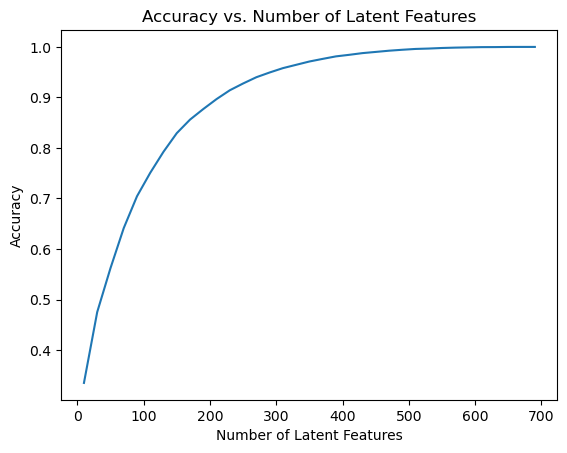

In [37]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [38]:
# Splitting data into training and testing sets
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - DataFrame containing the training data
    df_test - DataFrame containing the testing data
    
    OUTPUT:
    user_item_train - User-item matrix created from the training data
    user_item_test - User-item matrix created from the testing data
    test_idx - List of unique user IDs from the testing data
    test_arts - List of unique article IDs from the testing data
    '''
    # Create the user-item matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Extract user IDs and article IDs as lists
    test_idx = list(user_item_test.index.values)
    test_arts = list(user_item_test.columns.values)
    
    return user_item_train, user_item_test, test_idx, test_arts

# Calling the function to create matrices and retrieve lists of IDs
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [39]:
# How many users can we make predictions for in the test set?
train_users = set(df_train['user_id'].unique())
test_users = set(df_test['user_id'].unique())

# Find the intersection of the two sets and count the number of common users
common_users_count = len(train_users & test_users)

print(f"Number of users we can make predictions for in the test set: {common_users_count}")

Number of users we can make predictions for in the test set: 20


In [40]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
train_users = set(df_train['user_id'].unique())
test_users = set(df_test['user_id'].unique())

# Find users in the test set not present in the training set
cold_start_users_count = len(test_users - train_users)

print(f"Number of users in the test set we cannot make predictions for: {cold_start_users_count}")

Number of users in the test set we cannot make predictions for: 662


In [41]:
# How many articles can we make predictions for in the test set?
train_articles = set(df_train['article_id'].unique())
test_articles = set(df_test['article_id'].unique())

# Find articles present in both training and test sets
common_articles_count = len(train_articles & test_articles)

print(f"Number of articles we can make predictions for in the test set: {common_articles_count}")

Number of articles we can make predictions for in the test set: 574


In [42]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
train_articles = set(df_train['article_id'].unique())
test_articles = set(df_test['article_id'].unique())

# Find articles in the test set that are not in the training set
cold_start_articles_count = len(test_articles - train_articles)

print(f"Number of articles in the test set with the cold start problem: {cold_start_articles_count}")


Number of articles in the test set with the cold start problem: 0


In [43]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [44]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [45]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

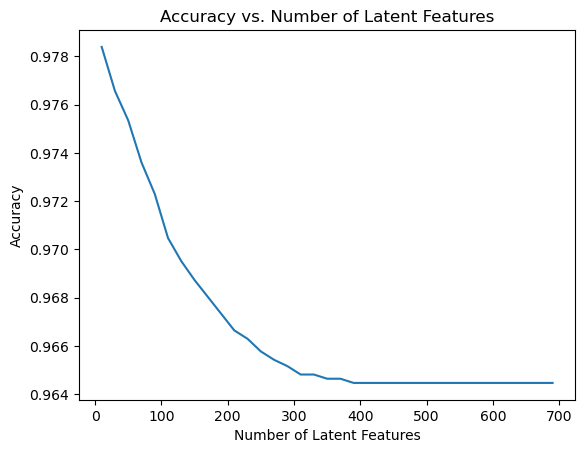

In [46]:
# Identify common users and articles between training and test datasets
common_users = np.intersect1d(test_idx, user_item_train.index)
common_articles = np.intersect1d(test_arts, user_item_train.columns)

# Filter test dataset to include only common users and articles
filtered_user_item_test = user_item_test.loc[
    user_item_test.index.isin(common_users), 
    user_item_test.columns.isin(common_articles)
]

# Get indices for the common users and articles in the training dataset
train_user_indices = [np.where(user_item_train.index == user)[0][0] for user in common_users]
train_article_indices = [np.where(user_item_train.columns == article)[0][0] for article in common_articles]

# Initialize a list to store errors and define the latent feature range
latent_features_range = np.arange(10, 710, 20)
errors = []

# Loop over different numbers of latent features
for k in latent_features_range:
    # Create reduced matrices for the current number of latent features
    u_reduced = u_train[:, :k]
    s_reduced = np.diag(s_train[:k])
    vt_reduced = vt_train[:k, :]
    
    # Get the corresponding reduced matrices for the test dataset
    test_user_matrix = u_reduced[train_user_indices, :]
    test_article_matrix = vt_reduced[:, train_article_indices]
    
    # Predict user-item interactions using matrix multiplication
    predicted_matrix = np.around(np.dot(np.dot(test_user_matrix, s_reduced), test_article_matrix))
    
    # Compute the error between actual and predicted values
    differences = np.abs(filtered_user_item_test.values - predicted_matrix)
    total_error = differences.sum()
    errors.append(total_error)

# Compute accuracy and plot the curve
accuracy = 1 - np.array(errors) / filtered_user_item_test.size
plt.plot(latent_features_range, accuracy)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

<a id='ProjectAnalysis'></a>
# Project Analysis and Final Recommendations

## SVD Analysis and A/B Testing Plan

For the test data, accuracy decreases as the number of latent features increases. This may occur because only 20 users are shared between the training and test datasets, leading to limited generalization. Additionally, there is a significant imbalance in user-article interactions, with most values being zero (sparse data).  

While adding latent features improves accuracy on the training data, it does not significantly enhance the test data's performance. This suggests potential overfitting. To address this, performing cross-validation could help identify the optimal number of latent features that generalize well across different subsets of the data.  

### Improvements:
- **Model Enhancements**: Incorporating regularization techniques (e.g., L2 regularization) or reducing the dimensionality of the dataset through feature engineering could mitigate overfitting.  
- **Alternative Algorithms**: Exploring other matrix factorization methods, such as Non-Negative Matrix Factorization (NMF), might yield better results for sparse data.  

### Evaluation:
SVD provides a clear improvement over rank-based recommendations and user-user collaborative filtering. To further evaluate its effectiveness, conducting A/B testing is recommended.  

### Steps for A/B Testing:
1. Ensure that each recommendation system receives an equal and randomized sample of users to avoid bias.  
2. Test only one variable at a time, such as comparing two recommendation systems, without testing other features concurrently.  
3. Allow the test to run for a sufficient duration to collect meaningful data for statistical significance.  
4. Complement quantitative data with qualitative insights by collecting user feedback through surveys or polls.  

By adhering to these principles, A/B testing can provide robust insights into user preferences and the effectiveness of the recommendation system.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [47]:
call(['python', '-m', 'nbconvert', '--to', 'html', 'Recommendations_with_IBM.ipynb'])

0